# Project Roadmap

1. Import project libraries

2. Data Wrangling

3. Analysis on Reddit Corpus
- Exploratory Data Analysis
- Sentiment Analysis

4. Speech Scores
- Speech Score Preparation
- Hate Speech
    - Importing data scraped from Wikipedia which contains a list of slurs
- Offensive Speech
    -  Importing data scraped from Wikipedia which contains a list of offensive speech
- Violent Speech
    -  Importing data scraped from Wikipedia which contains a list of violent speech

5. Clustering

## Import Project Libraries

In [1]:
# Import libraries

# Usual libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import string
import random
# NLTK
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Assigning variables
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stop_words = stopwords.words('english')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb
#import lightgbm as gbm
#from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Doc/Word Vectors
from gensim.models.fasttext import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

# LDA and LSI Models
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import LsiModel, CoherenceModel
from gensim.models import TfidfModel
from gensim.models import LdaModel, LdaMulticore
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Spacy
import spacy
from spacy.lang.en.examples import sentences
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
stopwords_nlp = nlp.Defaults.stop_words

# LIME and SHAP
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
#import shap

# Set seed
np.random.seed(123)

In [4]:
# Import dataset

#swited import to github folder set up from my local folder structure
df = pd.read_csv(r'/Users/daltonanderson/Documents/USF/Fall-2022/ISM6930 Text Analytics/Final Project Text Analysis on Social Platforms/NLProject-main/Reddit/data/iran_protest_corpus.csv')



df.head(2)

,id,subreddit,body,created
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09


## Data Wrangling

In [5]:
# Check for duplicates and drop if any
print(len(df))
df.drop_duplicates(['id'])
print(len(df))

8073
8073


In [6]:
# Loop through the column and clean the data

new_text = []

for text in df['body']:
    text = re.sub(r'[!"#$%&()*+,-./:;<=>?[\]^_`{|}~]', ' ', text).lower()               # Remove punctuation and make the letters lowercase
        
    words = nltk.tokenize.word_tokenize(text)                                           # Tokenize the text
    words = [w for w in words if w.isalpha()]                                           # Ensure the data is alphabets (remove numbers)
    words = [w for w in words if len(w)>1 and w not in stopwords.words('english')]      # Remove words that are less than 2 characters and stop words as well
        
    words = [lemmatizer.lemmatize(w) for w in words]                                    # Lemmatize the words
    new_text.append(' '.join(words))

# Make a copy of the original dataframe and add the cleaned text into a new column
df['cleaned_text'] = new_text
df.head()

,id,subreddit,body,created,cleaned_text
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...


## Analysis on Reddit Corpus

### Exploratory Data Analysis

<AxesSubplot:title={'center':'Subreddits'}>

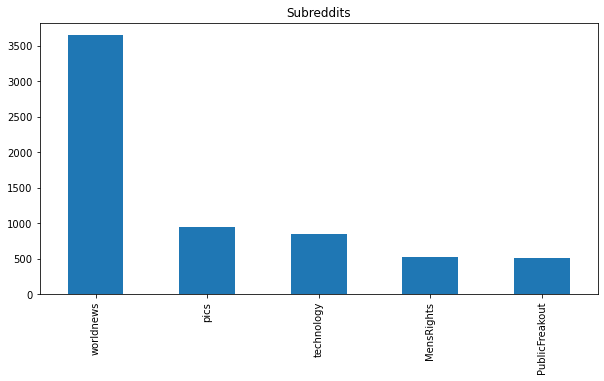

In [7]:
# Plot number of sources
df['subreddit'].value_counts().nlargest(5).plot(kind='bar', figsize=(10,5), title="Subreddits")

Interesting mens rights is one of the top 5 subreddits on a women's rights issue. 

### Sentiment Analysis

In [8]:
# Creating a copy of the dataframe
df_sentiment = df.copy()

In [9]:
df_sentiment['compound'] = df_sentiment['body'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df_sentiment['positive'] = df_sentiment['body'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['pos'])
df_sentiment['negative'] = df_sentiment['body'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['neg'])
df_sentiment.head()

,id,subreddit,body,created,cleaned_text,compound,positive,negative
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,-0.8074,0.083,0.348
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,-0.7097,0.000,0.258
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...,-0.9753,0.060,0.350
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response,-0.5994,0.000,0.496
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...,-0.9666,0.047,0.204


In [11]:
print('Compound:', df_sentiment['compound'].mean())
print('Positive:', df_sentiment['positive'].mean())
print('Negative:', df_sentiment['negative'].mean())

Compound: -0.025824080267558534
Positive: 0.11820128824476642
Negative: 0.1116451133407656


Text(0.5, 1.0, 'Polarity Score Distribution')

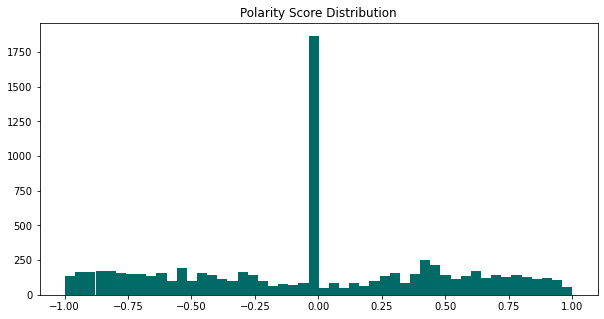

In [12]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['compound'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

In [13]:
# Trying Spacy
# lets create a new column with the sentiment of the comment

df_sentiment['sentiment'] = df_sentiment['body'].apply(lambda x: nlp(x)._.blob.polarity)

In [14]:
print('Text Blob Polartiy Score:', df_sentiment['sentiment'].mean())

Text Blob Polartiy Score: 0.055881402874080346


Text(0.5, 1.0, 'Polarity Score Distribution')

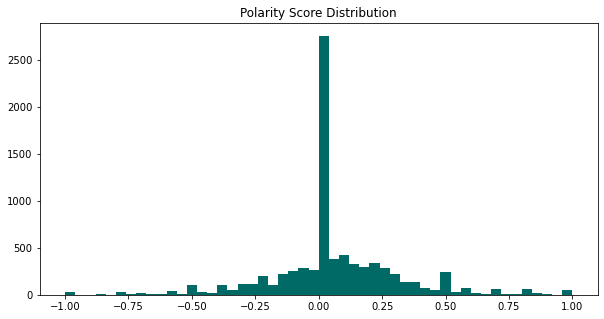

In [15]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['sentiment'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

Weird how different the outter tails are treated when compairing Text Blob VS NLTK

## Speech Scores

### Speech Score Preparation

In [16]:
# Define a function to clean the text better using Spacy
def clean_text(text):
    # make everything lowercase
    text = text.lower()
    # only lowercase letters no numbers or special characters
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub('https', ' ', text)
    
    # only accept nouns, pronouns and entities
    doc = nlp(text)
    text = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN', 'PRON', 'ADJ'] and len(token.text) > 3 \
        and token.text not in ('iranrevolution', 'iranprotests', 'iranrevoiution', 'freeiran', 'mahsaamini', 'mashaamini', 'iranians')]
    return text

In [25]:
# Apply function to dataframe
df['cleaned_text_ss'] = df['body'].apply(clean_text)
df.head()

,id,subreddit,body,created,cleaned_text,title,length,cleaned_text_ss
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,...",11,"[iran, western, stance, mass, protests, woman,..."
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover...",9,"[iran, past, years, west, west, iranian, gover..."
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...,"[what, interference, hostile, media, coverage,...",24,"[what, interference, hostile, media, coverage,..."
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response,"[their, protest, response, protests, response]",5,"[their, protest, response, protests, response]"
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...,"[this, best, original, reuters, world, middle,...",78,"[this, best, original, reuters, world, middle,..."


In [26]:
# Creating a new column with the length of the comment
df['length'] = df['cleaned_text_ss'].apply(lambda x: len(x))
df.head()

,id,subreddit,body,created,cleaned_text,title,length,cleaned_text_ss
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,...",12,"[iran, western, stance, mass, protests, woman,..."
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover...",8,"[iran, past, years, west, west, iranian, gover..."
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...,"[what, interference, hostile, media, coverage,...",28,"[what, interference, hostile, media, coverage,..."
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response,"[their, protest, response, protests, response]",5,"[their, protest, response, protests, response]"
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...,"[this, best, original, reuters, world, middle,...",83,"[this, best, original, reuters, world, middle,..."


In [27]:
# Gathering all the comments
all_comments = ' '.join(df['cleaned_text_ss'].apply(lambda x: ' '.join(x)))
len(all_comments)

664760

In [28]:
# Check how many unique words are in the comments
total_unique = len(set(all_comments.split()))

# Average unique words per comment
unique_words_by_comment = len(set(all_comments.split())) / len(all_comments.split())

In [29]:
# Check how many total words are in the comments
total_words = len(all_comments.split())
total_words

91896

In [30]:
# Check how many average words are in the comments
average_words_by_comment = len(all_comments.split()) / len(df)
average_words_by_comment

11.38312894834634

### Hate Speech

In [33]:
# Importing data scraped from Wikipedia which contains a list of slurs
df_hate = pd.read_csv(r'/Users/daltonanderson/Documents/USF/Fall-2022/ISM6930 Text Analytics/Final Project Text Analysis on Social Platforms/NLProject-main/GeneralData/ethnic_slurs.csv')

df_hate.head()

,Term,Location,Target,Meaning
0,abbie abe abie,north america,jewish men,originated before the 1950s from the proper na...
1,abc,east asia,americanborn chinese han or other chinese incl...,the term implies an otherness or lack of conne...
2,abcd,south asians in the us,americanborn confused desi indian americans or...,used chiefly by south asian immigrants to impl...
3,abidabeed plural,middle east and north africa,black african people,arabic for slave associated with the arab slav...
4,aboabbo,australia,australian aboriginal person,originally this was simply an informal term fo...


In [34]:
# make a set of all unique words in Term 
hate_terms = set()
for term in df_hate['Term']:
    for word in term.split():
        if len(word) < 4:
            continue
        hate_terms.add(word)

In [69]:
# check if the comments contain any of the hate words
hate_score = []
for comment in df['cleaned_text_ss']:
    hate_count = 0
    for content in comment:
        for word in hate_terms:
            if word in content:
                hate_count += 1

    hate_score.append(hate_count)

# add the hate score to the dataframe
df['hate_score'] = hate_score
df.head(2)

,id,subreddit,body,created,cleaned_text,title,length,cleaned_text_ss,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title,cluster
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,...",12,"[iran, western, stance, mass, protests, woman,...",2,0.0,1,8.333333,1,"['iran', 'western', 'stance', 'mass', 'protest...",3
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover...",8,"[iran, past, years, west, west, iranian, gover...",3,0.0,0,0.000000,0,"['iran', 'past', 'years', 'west', 'west', 'ira...",3


In [70]:
# get the top 5 rows with the highest hate score
df.sort_values(by='hate_score', ascending=False).head(2)

# Get the percentage of hate score devided by the total length of the comment
df['hate_score_percentage'] = df['hate_score'] / df['length'] * 100

# get the sum of the total hate score / sum of the total length of the comment * 100
percentage_total_hate = df['hate_score'].sum() / df['length'].sum() * 100
print(f"hate speech score: {percentage_total_hate:.2f}%")

hate speech score: 3.19%


### Offensive Speech

In [67]:
# Import offensive words list data
df_offensive = pd.read_csv(r'/Users/daltonanderson/Documents/USF/Fall-2022/ISM6930 Text Analytics/Final Project Text Analysis on Social Platforms/NLProject-main/GeneralData/offensive_words.csv')
df_offensive.head()



,Offensive_Words
0,arse
1,arsehead
2,arsehole
3,ass
4,asshole


In [71]:
# make a set of all unique words in Term 
offensive_terms = set()
for term in df_offensive['Offensive_Words']:
    for word in term.split():
        if len(word) < 2:
            continue
        offensive_terms.add(word)

In [72]:
# check if the comments contain any of the offensive words
offensive_score = []
for comment in df['cleaned_text_ss']:
    offensive_count = 0
    for content in comment:
        for word in offensive_terms:
            if word in content:
                offensive_count += 1

    offensive_score.append(offensive_count)

# add the offensive score to the dataframe
df['offensive_score'] = offensive_score
df.head(2)

,id,subreddit,body,created,cleaned_text,title,length,cleaned_text_ss,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title,cluster
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,...",12,"[iran, western, stance, mass, protests, woman,...",2,16.666667,1,8.333333,1,"['iran', 'western', 'stance', 'mass', 'protest...",3
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover...",8,"[iran, past, years, west, west, iranian, gover...",3,37.500000,0,0.000000,0,"['iran', 'past', 'years', 'west', 'west', 'ira...",3


In [73]:
# get the top 5 rows with the highest offensive score
df.sort_values(by='offensive_score', ascending=False).head(2)

# Get the percentage of offensive score devided by the total length of the comment
df['offensive_score_percentage'] = df['offensive_score'] / df['length'] * 100

# get the sum of the total offensive score / sum of the total length of the comment * 100
percentage_total_offensive = df['offensive_score'].sum() / df['length'].sum() * 100
f"{percentage_total_offensive:.2f}%"

'2.30%'

### Violent Speech

In [74]:
# Import offensive words list data
df_violent = pd.read_csv(r'/Users/daltonanderson/Documents/USF/Fall-2022/ISM6930 Text Analytics/Final Project Text Analysis on Social Platforms/NLProject-main/GeneralData/violent_words.csv')
df_violent.head()

,Violent_Words
0,acid
1,aggressor
2,agitator
3,aim
4,alert


In [75]:
# make a set of all unique words in Term 
violent_terms = set()
for term in df_violent['Violent_Words']:
    for word in term.split():
        if len(word) < 4:
            continue
        violent_terms.add(word)

In [76]:
# check if the comments contain any of the violent words
violent_score = []
for comment in df['cleaned_text_ss']:
    violent_count = 0
    for content in comment:
        for word in violent_terms:
            if word in content:
                violent_count += 1

    violent_score.append(violent_count)

# add the violent score to the dataframe
df['violent_score'] = violent_score
df.head(2)

,id,subreddit,body,created,cleaned_text,title,length,cleaned_text_ss,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title,cluster
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,...",12,"[iran, western, stance, mass, protests, woman,...",2,16.666667,1,8.333333,1,"['iran', 'western', 'stance', 'mass', 'protest...",3
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover...",8,"[iran, past, years, west, west, iranian, gover...",3,37.500000,0,0.000000,0,"['iran', 'past', 'years', 'west', 'west', 'ira...",3


In [77]:
df2 = df.copy()

In [78]:
df2 = df2[df2['length'] > 1]

In [79]:
# get the top 5 rows with the highest violent score
df2.sort_values(by='violent_score', ascending=False).head(2)

# Get the percentage of violent score devided by the total length of the comment
df2['violent_score_percentage'] = df2['violent_score'] / df2['length'] * 100

# get the sum of the total violent score / sum of the total length of the comment * 100
percentage_total_violent = df2['violent_score'].sum() / df2['length'].sum() * 100
f"{percentage_total_violent:.2f}%"

'6.00%'

In [80]:
# Create a dataframe of the calculated scores

scores_combined_df = pd.DataFrame([['Score Measures',percentage_total_hate, percentage_total_offensive, percentage_total_violent]],
    columns = ['Values','Hate', 'Offensive', 'Violent'])

scores_combined_df

,Values,Hate,Offensive,Violent
0,Score Measures,3.193828,2.296074,5.997372


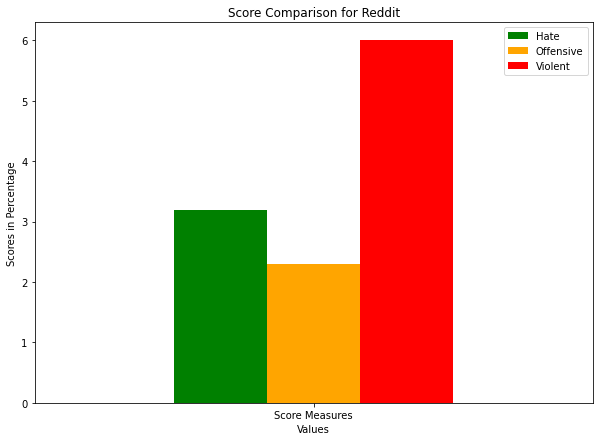

In [81]:
# Plot Scores for comparison

scores_combined_df.plot(x='Values', y=['Hate', 'Offensive', 'Violent'], kind = 'bar', figsize=(10,7), color = ['green', 'orange', 'red'])
plt.xticks(rotation = 360)
plt.ylabel('Scores in Percentage')
plt.title('Score Comparison for Reddit')
plt.show()

## Feature Extraction

In [82]:
# Create a new column to convert the title column from list to string

df['str_title'] = df['title'].astype(str)
df.dtypes

id                             object
subreddit                      object
body                           object
created                       float64
cleaned_text                   object
title                          object
length                          int64
cleaned_text_ss                object
hate_score                      int64
hate_score_percentage         float64
offensive_score                 int64
offensive_score_percentage    float64
violent_score                   int64
str_title                      object
cluster                         int32
dtype: object

In [51]:
# For loop to extract features based on positive reviews

feature_extractions = dict()                                # Create a dictionary

for index, row in df.iterrows():                            # Iterate through each row for the positive comments column
    doc = nlp(row["str_title"])
    for token in doc:                                       # Iterate through each word within that row
        if token.text not in ("'", 'iranrevolution', 'iranprotests', 'iranrevoiution', 'freeiran', 'mahsaamini', 'mashaamini', 'iranians'):
            if token.pos_ == 'NOUN':                            # Get the nouns from the sentences
                if token.text in feature_extractions:           # Count the number of times the noun appears
                    feature_extractions[token.text] +=1
                else:
                    feature_extractions[token.text] = 1

# Sort the dictionary where the highest number of features are on the top, then show the top 10 features
feature_extractions_sorted = sorted(feature_extractions.items(), key = lambda x: x[1], reverse = True)
top_five_feature_extractions = feature_extractions_sorted[0:10]
top_five_feature_extractions

[('people', 1851),
 ('women', 1283),
 ('government', 607),
 ('religion', 516),
 ('country', 473),
 ('protests', 413),
 ('regime', 398),
 ('time', 375),
 ('world', 364),
 ('police', 290)]

In [52]:
# View Full List
feature_extractions_sorted

[('people', 1851),
 ('women', 1283),
 ('government', 607),
 ('religion', 516),
 ('country', 473),
 ('protests', 413),
 ('regime', 398),
 ('time', 375),
 ('world', 364),
 ('police', 290),
 ('rights', 285),
 ('power', 284),
 ('shah', 278),
 ('death', 275),
 ('things', 275),
 ('thing', 257),
 ('countries', 255),
 ('years', 233),
 ('west', 230),
 ('point', 223),
 ('revolution', 215),
 ('woman', 204),
 ('state', 202),
 ('church', 194),
 ('shit', 192),
 ('freedom', 191),
 ('hair', 180),
 ('protest', 173),
 ('fact', 172),
 ('comments', 165),
 ('life', 160),
 ('internet', 158),
 ('place', 157),
 ('comment', 146),
 ('human', 143),
 ('wrong', 140),
 ('history', 138),
 ('reason', 134),
 ('support', 134),
 ('fuck', 131),
 ('part', 129),
 ('problem', 121),
 ('media', 120),
 ('military', 120),
 ('family', 119),
 ('girls', 118),
 ('others', 117),
 ('change', 116),
 ('post', 115),
 ('east', 114),
 ('protesters', 113),
 ('whole', 113),
 ('person', 112),
 ('choice', 112),
 ('oppression', 106),
 ('proxy'

In [55]:
feature_extractions_sorted_df = pd.DataFrame (feature_extractions_sorted, columns = ['word', 'frequency'])
#take the top 20
feature_extractions_sorted_df = feature_extractions_sorted_df.head(20)

In [57]:
feature_extractions_sorted_df

,word,frequency
0,people,1851
1,women,1283
2,government,607
3,religion,516
4,country,473
5,protests,413
6,regime,398
7,time,375
8,world,364
9,police,290


Text(0, 0.5, 'Frequence of Each Word')

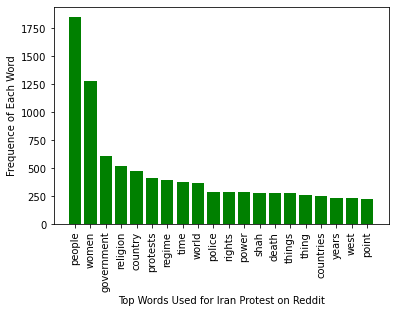

In [61]:

plt.bar(feature_extractions_sorted_df['word'], feature_extractions_sorted_df['frequency'], color = 'green')
plt.xticks(rotation=90)
plt.xlabel("Top Words Used for Iran Protest on Reddit")
plt.ylabel("Frequence of Each Word")

## Clustering

In [83]:
# Performing clustering to find the number of natural clusters in the data

# Perform a natural clustering on the comments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# create a list of all the comments
all_comments = list()
for comment in df['cleaned_text_ss']:
    all_comments.append(' '.join(comment))

# create a tfidf vectorizer object
vectorizer = TfidfVectorizer(stop_words='english')

# fit the vectorizer to the comments
X = vectorizer.fit_transform(all_comments)

# create a kmeans object
kmeans = KMeans(n_clusters=5, random_state=0)

# fit the kmeans object to the vectorizer
kmeans.fit(X)

# get the cluster labels
labels = kmeans.labels_

# add the cluster labels to the dataframe
df['cluster'] = labels
df.head(10)

,id,subreddit,body,created,cleaned_text,title,length,cleaned_text_ss,hate_score,hate_score_percentage,offensive_score,offensive_score_percentage,violent_score,str_title,cluster
0,ipwiccq,worldnews,> Iran protests Western stance on mass protest...,1.664147e+09,iran protest western stance mass protest woman...,"[iran, western, stance, mass, protests, woman,...",12,"[iran, western, stance, mass, protests, woman,...",2,16.666667,1,8.333333,1,"['iran', 'western', 'stance', 'mass', 'protest...",3
1,ipvtdwd,worldnews,"Iran for the past 40+ years: ""Fuck the west"" ...",1.664137e+09,iran past year fuck west west dont like irania...,"[iran, past, years, west, west, iranian, gover...",8,"[iran, past, years, west, west, iranian, gover...",3,37.500000,0,0.000000,0,"['iran', 'past', 'years', 'west', 'west', 'ira...",3
2,ipvyfc3,worldnews,""" ... over what it called interference and ho...",1.664139e+09,called interference hostile medium coverage na...,"[what, interference, hostile, media, coverage,...",28,"[what, interference, hostile, media, coverage,...",2,7.142857,0,0.000000,5,"['what', 'interference', 'hostile', 'media', '...",0
3,ipvpcc7,worldnews,We should protest their protest response prote...,1.664135e+09,protest protest response protest response,"[their, protest, response, protests, response]",5,"[their, protest, response, protests, response]",0,0.000000,0,0.000000,0,"['their', 'protest', 'response', 'protests', '...",0
4,ipvrv10,worldnews,"This is the best tl;dr I could make, [original...",1.664136e+09,best tl dr could make original http www reuter...,"[this, best, original, reuters, world, middle,...",83,"[this, best, original, reuters, world, middle,...",1,1.204819,2,2.409639,2,"['this', 'best', 'original', 'reuters', 'world...",3
5,ipvr017,worldnews,"Western response should be ""lol fuck you""\nOne...",1.664136e+09,western response lol fuck one hope turning poi...,"[western, response, fuck, this, turning, point...",16,"[western, response, fuck, this, turning, point...",2,12.500000,1,6.250000,1,"['western', 'response', 'fuck', 'this', 'turni...",3
6,ipvqd6z,worldnews,"They were shouting ""Death to America!"" well be...",1.664136e+09,shouting death america well shit fault younger...,"[they, death, america, shit, fault, their, you...",18,"[they, death, america, shit, fault, their, you...",0,0.000000,3,16.666667,1,"['they', 'death', 'america', 'shit', 'fault', ...",0
7,ipvq69o,worldnews,Sends weapons to Russia. Denounces the US ever...,1.664136e+09,sends weapon russia denounces u every verse en...,"[weapons, russia, verse, doesn, wests, stance,...",10,"[weapons, russia, verse, doesn, wests, stance,...",1,10.000000,0,0.000000,1,"['weapons', 'russia', 'verse', 'doesn', 'wests...",0
8,ipwq5o4,worldnews,We have protests all the time here. We don't s...,1.664151e+09,protest time shut internet,"[protests, time, internet]",3,"[protests, time, internet]",0,0.000000,0,0.000000,0,"['protests', 'time', 'internet']",0
9,ipwn0v2,worldnews,I think if they're at the point where they've ...,1.664149e+09,think point cut communication line order deal ...,"[they, point, they, communication, lines, orde...",10,"[they, point, they, communication, lines, orde...",0,0.000000,0,0.000000,2,"['they', 'point', 'they', 'communication', 'li...",0


/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


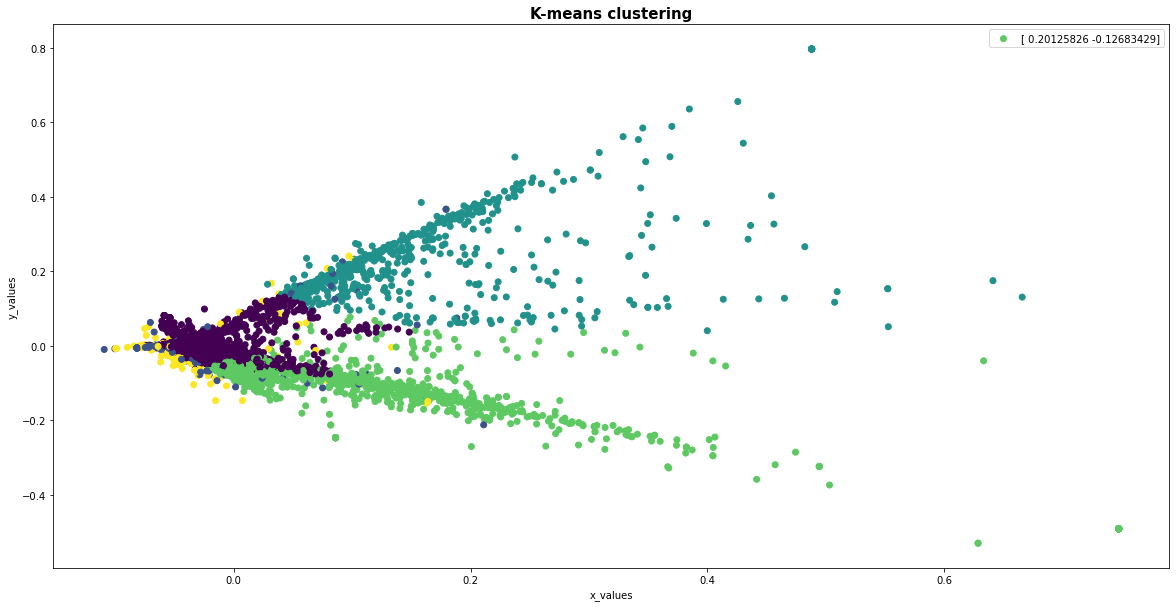

In [84]:
# Plot the clusters
from sklearn.decomposition import PCA

# create a pca object
pca = PCA(n_components=2)

# fit the pca object to the vectorizer
pca.fit(X.toarray())

# get the first two principal components
data2D = pca.transform(X.toarray())

# plot the clusters
plt.figure(figsize=(20,10))
plt.scatter(data2D[:,0], data2D[:,1], c=labels)
# Add legend, title and axis names
plt.legend(data2D)
plt.title('K-means clustering', fontsize=15, fontweight='bold')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.show()

In [85]:
# Check the top 10 words in each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print('\n')

Cluster 0:
 people
 time
 hair
 government
 protests
 iranian
 shit
 country
 regime
 thing


Cluster 1:
 good
 people
 luck
 iranian
 america
 thing
 women
 brave
 country
 fight


Cluster 2:
 women
 rights
 iran
 hijab
 iranian
 muslim
 people
 hair
 brave
 feminists


Cluster 3:
 iran
 people
 government
 iranian
 country
 protests
 regime
 world
 shah
 power


Cluster 4:
 religion
 people
 islam
 evil
 religious
 problem
 politics
 government
 world
 religions




/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [86]:
# Get 5 random comments from each cluster
for i in range(5):
    print("Cluster %d:" % i)
    for comment in df[df['cluster'] == i]['title'].sample(5):
        print(' '.join(comment))
    print('\n')

Cluster 0:
what divorce

muslims
world ignorant narrow minded bigots people lies many converts islam neighbours colleagues friends family members they muslim what true
rare thing things things


Cluster 1:
iranian baddie good pussy
iranian people what game good israel good iranian people theocrats show putin reasonable democratic lease good nato russia ukraine
good call persians similar other americans they their culture everyone friends unlalike maya angelou
your country streets dictator willing same your country disconnected reality brain cells good
sure people good hell most religions


Cluster 2:
jobs same women this hard
human rights abuses notions creeds laws that people reality they products ideals ideologies which women many ideologies they they interests women their lives religious traditions that their sisters mothers grand mothers
america women
favour your oppression anti suffrage movement women worth hijab oppressive itself forced hijab
women ones themselves people times op

### Clustering on Hate Score

In [88]:
# Get 5 random comments from each cluster
for i in range(5):
    print("Cluster %d:" % i)
    for comment in df[df['cluster'] == i]['title'].sample(5):
        print(' '.join(comment))
    print('\n')

Cluster 0:
area expertise

american bear mind free free other people true freedom doesn scale freedom everyone world guys fucking free

triple double stamp


Cluster 1:
guns knives group guys armed cops brick them their weapons good
news yourself criminal regime which people side choice attention this good night
info good luck bridget small levity symbolism same time
france good thing they religious symbols schools free expression good thing
good them


Cluster 2:
things people your initial argument feminists special protections answer conservative movement part hayden rider modification quotes supporters original amendment original purpose amendment house eleanor roosevelt most dealers they middle class women class women government protection section hayden equal rights amendment discussion feminists meaning women equality paul national woman party women equal terms regards that benefits women protective legislation such shorter work hours night work heavy lifting feminists single mon